In [ ]:
# algorithm is model-free and off-policy

In [ ]:
# prompt: connect to google drive and change directory

from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/My Drive/dqn") #Change your-desired-directory to your desired directory


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%ls

breakout_videos/  models/


# Algorithm

create a neural network



for t in episodes:
  


## Questions

- How is reward calculated at each step?


In [ ]:
!pip install "gym[atari, accept-rom-license]"

In [ ]:
import gym
import numpy as np
from gym import spaces
import cv2
from collections import deque

cv2.ocl.setUseOpenCL(False)
## Wrappers referenced from OpenAI (https://github.com/openai/baselines)
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,) + env.observation_space.shape, dtype=np.uint8)
        self._skip = skip

    def reset(self):
        return self.env.reset()

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, truncated, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)
        return max_frame, total_reward, done, truncated, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

class PreprocessFrame(gym.ObservationWrapper):
    def __init__(self, env):
        """Warp frames to 84x84 as done in the Nature paper and later work.
        Expects inputs to be of shape height x width x num_channels
        """
        gym.ObservationWrapper.__init__(self, env)
        self.observation_space = spaces.Box(low=0, high=255,
                                            shape=(84, 84, 1), dtype=np.uint8)
    def observation(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (84, 110), interpolation=cv2.INTER_AREA)
        frame = frame[18:102, :]
        return frame

    # def observation(self, frame):
    #     # grey-scale: (210, 160, 3) -> (210, 160)
    #     img = np.dot(frame[...,:3], [0.299, 0.587, 0.114])
    #     # down-sample to 110x84 image: (210, 160) -> (110, 84)
    #     img = resize(img, (110, 84), anti_aliasing=False)
    #     # crop to 84x84: (110, 84) -> (84, 84)
    #     new_frame = img[18:102, :]
    #     return new_frame

class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        """Stack k last frames.
        Returns lazy array, which is much more memory efficient.
        Expects inputs to be of shape num_channels x height x width.
        """
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = spaces.Box(low=0, high=255, shape=(shp[0], shp[1], shp[2] * k), dtype=np.uint8)

    def reset(self):
        ob, info = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        return self._get_ob()

    def step(self, action):
        ob, reward, done, truncated, info = self.env.step(action)
        self.frames.append(ob)
        return self._get_ob(), reward, done, truncated, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return np.stack(self.frames, axis=-1)


In [ ]:
env = gym.make("ALE/Breakout-v5")
env = MaxAndSkipEnv(env, skip=4)
env = PreprocessFrame(env)
env = FrameStack(env, k=4)

x = env.reset()
print(x.shape)

# plt.imshow(x[0])

print(env.observation_space)

(84, 84, 4)
Box(0, 255, (84, 84, 4), uint8)


In [ ]:
# # prompt: display the rgb image

# import matplotlib.pyplot as plt

# plt.imshow(img[0])
# plt.show()


In [ ]:
from skimage.transform import resize

def preprocessImage(img):
  # grey-scale: (210, 160, 3) -> (210, 160)
  img = np.dot(img[...,:3], [0.299, 0.587, 0.114])
  # down-sample to 110x84 image: (210, 160) -> (110, 84)
  img = resize(img, (110, 84), anti_aliasing=False)
  # crop to 84x84: (110, 84) -> (84, 84)
  img = img[18:102, :]
  return img


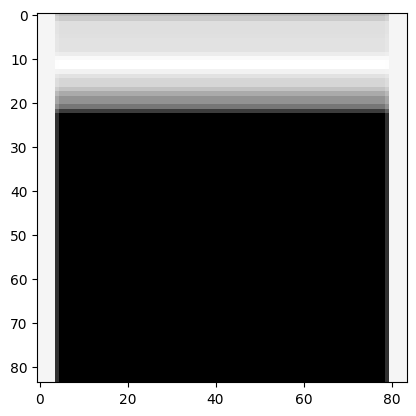

In [ ]:
# prompt: display a grayscale image
processed_image = preprocessImage(x)

import matplotlib.pyplot as plt
plt.imshow(processed_image, cmap='gray')
plt.show()

In [ ]:
from collections import deque
class ReplayMemory():
  def __init__(self, capacity=10000):
    self.memory = deque([], maxlen=capacity)
    self.capacity = capacity

  def append(self, obj):
    self.memory.append(obj)

  def sampleItems(self, batch_size, history_size=4):
    random_indices = np.random.choice(len(self.memory), batch_size, replace=True)
    return [self.memory[i] for i in random_indices]

  def display(self):
    print(self.memory)

In [ ]:
replay_memory = ReplayMemory(capacity=2)

for i in range(10):
  replay_memory.append(i)
  replay_memory.display()

deque([0], maxlen=2)
deque([0, 1], maxlen=2)
deque([1, 2], maxlen=2)
deque([2, 3], maxlen=2)
deque([3, 4], maxlen=2)
deque([4, 5], maxlen=2)
deque([5, 6], maxlen=2)
deque([6, 7], maxlen=2)
deque([7, 8], maxlen=2)
deque([8, 9], maxlen=2)


In [ ]:
# class AtariState:
#   def __init__(self, num_frames=4):
#     self.memory = deque([], maxlen=num_frames)
#     self.num_frames = num_frames

#   def append(self, frame):
#     self.memory.append(frame)
#     if len(self.memory) > self.capacity:
#       self.memory.popleft()

#   def sampleItems(self, batch_size, history_size=4):
#     random_indices = np.random.choice(len(self.memory), batch_size, replace=True)
#     return [self.memory[i] for i in random_indices]

#   def get(self):
#     if len(self.memory) < self.num_frames:
#       raise Exception("Not enough frames in memory")
#     return np.stack(self.memory)

#   def getStateWithNextFrame(self, next_frame):
#     if len(self.memory) < self.num_frames:
#       raise Exception("Not enough frames in memory")

#     oldest_frame = self.memory[0]
#     self.memory.popleft()
#     self.memory.append(next_frame)
#     next_state = np.stack(self.memory)
#     self.memory.appendleft(oldest_frame)
#     return next_state

#   def display(self):
#     print(self.memory)

In [ ]:
from logging import exception
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Flatten, Dense
import tensorflow as tf
from keras.optimizers import Adam
from keras.src.legacy.saving import legacy_h5_format

class DeepQNetwork():
  def __init__(self, input_shape=(84, 84, 4), output_size=4):
    self.model = self.makeModel(input_shape, output_size)
    self.output_size = output_size
  def makeModel(self, input_shape, output_size):
    model = keras.Sequential(name='deep_q_network')
    # convolution 15 8x8 filters with stide=4
    model.add(Conv2D(16, kernel_size=(8, 8), strides=(4, 4), activation='relu', input_shape=input_shape))
    # convolution 32 4x4 filters with stride=2
    model.add(Conv2D(32, kernel_size=(4, 4), strides=(2, 2), activation='relu'))
    # Flatten the output
    model.add(Flatten())
    # 256 rectifier units
    model.add(Dense(256, activation='relu'))
    # Output layer
    model.add(Dense(output_size, activation='softmax'))

    model.compile(loss='mse', optimizer=Adam())

    return model

  def predict(self, input):
    return self.model.predict(input)

  def getModel(self):
    return self.model

  def loadModel(self, path):
    if path is None:
      raise exception("No path is passed to loadModel call")
    return keras.models.load_model(path)

  def loadModelOnlyForInference(self, path):
    self.model = legacy_h5_format.load_model_from_hdf5(path, custom_objects={'mse': 'mse'})

  def train(self, batch):
    # cur_state, action, total_reward, next_state, done
    loss_function = keras.losses.Huber()
    optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)

    rewards_so_far = []
    future_rewards = []
    next_states = []
    actions = []
    dones = []
    states = []

    for i in range(len(batch)):
      cur_state, action, reward, next_state, done = batch[i]
      rewards_so_far.append(reward)
      states.append(cur_state)
      next_states.append(next_state)
      actions.append(action)
      dones.append(done)

    next_q_values = [q_values for q_values in self.predict(np.stack(next_states))]
    target_q_values = rewards_so_far + gamma * keras.ops.amax(next_q_values, axis=1)
    # set q_value to -1 if end-state ??
    target_q_values = np.multiply(target_q_values, (np.ones(len(dones)) - dones) - dones)

    # Create a mask so we only calculate loss on the updated Q-values
    masks = keras.ops.one_hot(actions, self.output_size)

    with tf.GradientTape() as tape:
        q_values = self.predict(np.stack(states))
        # Apply the masks to the Q-values to get the Q-value for action taken
        q_action = keras.ops.sum(keras.ops.multiply(q_values, masks), axis=1)
        # Calculate loss between new Q-value and old Q-value
        loss = loss_function(target_q_values, q_action)


In [ ]:
dqn = DeepQNetwork()

dqn.getModel().summary()
# dqn.getModel().trainable_variables

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "deep_q_network"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 20, 20, 16)          │           4,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 9, 9, 32)            │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2592)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         663,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 677,172 (2.58 MB)

 Trainable params: 677,172 (2.58 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
np.random.rand()

0.06734253944818369

In [ ]:
import datetime

num_episodes = 1  # Number of episodes to run
epsilon = 1.0
epsilon_decay = 0.995
min_epsilon = 0.1
gamma = 0.5
alpha = 0.1
minibatch_size = 32
frame_skip_frequency = 4
max_frames = 100000
save_interval = 20

# Explore:
# 0. how the action q-values are changing
# 1. if epsilon is set for each episode?
# 2. if we need to normalize action q-values
# 3. if we need to clip rewards
# 4. Why end_state q_value should be -1?
# 5. is exploration done with prob epsilion or (1 - epsilon)?

replay_memory = ReplayMemory()
dqn = DeepQNetwork()

env = gym.make("ALE/Breakout-v5")
env = MaxAndSkipEnv(env, skip=4)
env = PreprocessFrame(env)
env = FrameStack(env, k=4)

for episode in range(num_episodes):
  cur_state = env.reset()
  done = False
  total_reward = 0
  step_no = 0

  while not done:
    step_no += 1
    # Get action from neural network
    action_probs = dqn.predict(cur_state[None, :, :, :])

    if np.random.rand() < epsilon: # if rand is between [0, epsilon)
      action = env.action_space.sample()
    else:
      action = np.argmax(action_probs)

    # Interact with the environment
    next_state, cur_reward, done, truncated, info = env.step(action)
    total_reward += cur_reward

    replay_memory.append((cur_state, action, total_reward, next_state, done))

    if step_no % minibatch_size == 0:
      print(f'Steps count: {step_no}. Performing a mini-batch train...')
      batch = replay_memory.sampleItems(minibatch_size)
      dqn.train(batch)

    if epsilon > min_epsilon:
      epsilon *= epsilon_decay

    # Update the state and total reward
    cur_state = next_state

  print(f'Total steps count: {step_no}')
  env.close()

  if episode != 0 and episode % save_interval == 0:
    print('Saving the model trained so far...')
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    model_filename = f"models/breakout_dqn_model_{timestamp}_{episode}.h5"
    dqn.getModel().save(model_filename)
    print(f"Model saved as {model_filename}")
# """"
# 2 ways:
# 1. based on the frequency number, skip taking action on every frame and use only the 4th one and accumulated ones
# 2. keep everything in queue, based on the sampled indices, pick the last [i - k, i] frames.


# Questions:
# 1. What to do when frames are missing?
# """"

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

In [ ]:
env.observation_space

Box(0, 255, (84, 84, 4), uint8)

In [ ]:
# prompt: load keras model from a file

from tensorflow import keras

# Load the model
loaded_model = keras.models.load_model('models/breakout_dqn_model_20250310_105002_60.h5') # Replace with your model file

# Now you can use the 'model' object to make predictions
# For example:
# predictions = model.predict(some_input_data)





TypeError: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}

In [ ]:
# prompt: play the env using newly trained DeepQNetwork model. Record and play the video as well

import gym
from gym.wrappers import RecordVideo
import numpy as np

# Create the environment with video recording
env = gym.make("ALE/Breakout-v5", render_mode="rgb_array")
env = RecordVideo(env, video_folder="breakout_videos") # Save videos to breakout_videos directory
env = MaxAndSkipEnv(env, skip=4)
env = PreprocessFrame(env)
env = FrameStack(env, k=4)
dqn = DeepQNetwork()
dqn.loadModelOnlyForInference('models/breakout_dqn_model_20250310_105002_60.h5')

frames_limit = 2000
# Play the game using the trained model and record the video
num_episodes = 1
for episode in range(num_episodes):
    state = env.reset()
    done = False
    total_reward = 0
    frame_no = 0
    while not done:
      action_probs = dqn.predict(state[None, :, :, :])
      action = np.argmax(action_probs)  # Choose the best action
      print(action)
      next_state, reward, done, truncated, info = env.step(action)
      state = next_state
      total_reward += reward
      frame_no += 1
      if frame_no > frames_limit:
        break

    print(f"Episode {episode + 1}: Total Reward = {total_reward}")
    env.close()


/usr/local/lib/python3.11/dist-packages/gym/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /content/drive/MyDrive/dqn/breakout_videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
0


Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/dqn/breakout_videos/rl-video-episode-0.mp4


In [ ]:
env.action_space.sample()

3

In [ ]:
# random walk
import gym
from gym.wrappers import RecordVideo
import numpy as np

# Create the environment with video recording
env = gym.make("ALE/Breakout-v5", render_mode="rgb_array")
env = RecordVideo(env, video_folder="breakout_videos", name_prefix='random_walk') # Save videos to breakout_videos directory
env = MaxAndSkipEnv(env, skip=4)
env = PreprocessFrame(env)
env = FrameStack(env, k=4)
dqn = DeepQNetwork()
dqn.loadModelOnlyForInference('models/breakout_dqn_model_20250310_105002_60.h5')

frames_limit = 200
# Play the game using the trained model and record the video
num_episodes = 1
for episode in range(num_episodes):
    state = env.reset()
    done = False
    total_reward = 0
    frame_no = 0
    while not done:
      action = env.action_space.sample()
      print(action)
      next_state, reward, done, truncated, info = env.step(action)
      state = next_state
      total_reward += reward
      frame_no += 1
      if frame_no > frames_limit:
        break

    print(f"Episode {episode + 1}: Total Reward = {total_reward}")
    env.close()


/usr/local/lib/python3.11/dist-packages/gym/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /content/drive/MyDrive/dqn/breakout_videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a depr

1
3
3
0
2
3
3
2
0
3
3
3
2
3
2
3
2
0
1
1
0
1
3
2
1
2
1
0
2
3
2
0
3
3
3
2
3
3
0
3
1
3
2
2
0
0
2
1
1
3
2
2
3
2
1
1
0
3
2
3
3
Moviepy - Building video /content/drive/MyDrive/dqn/breakout_videos/random_walk-episode-0.mp4.
Moviepy - Writing video /content/drive/MyDrive/dqn/breakout_videos/random_walk-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/dqn/breakout_videos/random_walk-episode-0.mp4
Episode 1: Total Reward = 2.0


In [ ]:
# prompt: save the keras model with current timestamp

import datetime

# Assuming 'dqn' is your trained DeepQNetwork instance and 'model' is its Keras model
model = dqn.getModel()

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f"breakout_dqn_model_{timestamp}.h5"
model.save(model_filename)
print(f"Model saved as {model_filename}")


In [ ]:
# prompt: find python version

!python --version


In [ ]:
env = gym.make("ALE/Breakout-v5")

frame = env.reset()
# print(frame[0])
frame = preprocessImage(frame[0])
print(frame.shape)
frames = [ frame[:,:] for _ in range(4)]

new_state = np.stack(frames, axis=-1)
print(new_state.shape)


In [ ]:
# prompt: create a random numpy of (4, 84, 84)

import numpy as np

# Create a random NumPy array of shape (4, 84, 84)
random_array = np.random.rand(4, 84, 84)

random_array.shape

x = [y for y in random_array]

for i in x:
  print(i.shape)



## References

- https://danieltakeshi.github.io/2016/11/25/frame-skipping-and-preprocessing-for-deep-q-networks-on-atari-2600-games/